# Часть 2 (Применение современных NLP моделей)

# 1. Загрузка данных и составление датасета - как в 1 части

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
dataset = pd.read_csv("/content/drive/MyDrive/full_dataset.csv")

In [3]:
dataset.head()

,cleaned_text,real
0,wing voters. A BBC report from 2012 showed tha...,1
1,"right, as Bannon has bragged. In other words, ...",1
2,WASHINGTON — President Obama had “an intens...,0
3,year old man is on suspicion of failure to dis...,1
4,You may have read or heard about the study deb...,0


In [4]:
text = dataset['cleaned_text'].tolist()
real = dataset['real'].tolist()

# 2. Здесь будем экспериментировать с 4мя способами предобработки

In [5]:
import nltk
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = list(set(stopwords.words("english")))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
def stopwords_special(text):
  text = text.lower()
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in stop_words]  # убираем стоп-слова
  tokens = word_tokenize(re.sub(r'[^a-zA-Zа-яА-Я ]', '', ' '.join(tokens)))  # убираем спец символы, числа и знаки препинания
  return tokens

In [7]:
nltk.download('wordnet')
nltk.download('omw-1.4')

# стемминг
def stemming(text):
  tokens = stopwords_special(text)
  stemmer = nltk.PorterStemmer()  # инициализируем стеммер
  stemmed_tokens = [stemmer.stem(token) for token in tokens]  # перебираем токены и применяем алгоритм стемминга

  return stemmed_tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
def lemma(text):
  tokens = stopwords_special(text)
  lemmatizer = nltk.WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

  return lemmatized_tokens

# 3. WordCloud

In [9]:
!pip install wordcloud

In [10]:
!pip install tensorflow==2.12.0

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [12]:
!pip uninstall numpy -y
!pip install numpy==1.23.5

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer  # токенезация текста
from tensorflow.keras.preprocessing.sequence import pad_sequences  # выравнивание последовательности до одной длины
from tensorflow.keras.models import Sequential  # линейные слои
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, GlobalMaxPooling1D, Dropout
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

*Проанализируем датасет через WordCloud*

In [14]:
text1 = " ".join(text)

In [15]:
wordcloud1 = WordCloud(width=1920, height=1080).generate(text1)

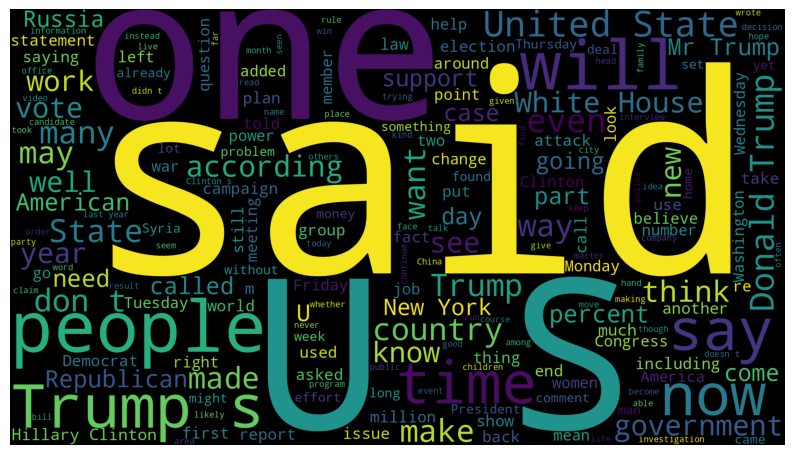

In [16]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1)
plt.axis("off")
plt.show()

# 4. Токенезация Tokenizer - текст без преобработки

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train_nothing, X_test_nothing, y_train_nothing, y_test_nothing = train_test_split(text, real, test_size=0.2, random_state=42)

In [19]:
token = Tokenizer()

In [20]:
token.fit_on_texts(X_train_nothing)

In [21]:
word_idx = token.word_index
v = len(word_idx)
print("Размер словаря = ", v)

Размер словаря =  171290


In [22]:
X_train_nothing = token.texts_to_sequences(X_train_nothing)
X_test_nothing = token.texts_to_sequences(X_test_nothing)

In [23]:
# унифицируем длину входящей последовательности до 250
X_train_nothing = pad_sequences(X_train_nothing, maxlen=250)
X_test_nothing = pad_sequences(X_test_nothing, maxlen=250)

# 5. Создание и обучение модели - без предобработки текста

In [24]:
input1 = Input(shape=(250,))
learning_rate = 1e-4

x = Embedding(v+1,100)(input1)
x = Dropout(0.5)(x)
x = LSTM(150,return_sequences=True)(x)
x = Dropout(0.5)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

model = Model(input1, x)

# Оптимайзер
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 100)          17129100  
                                                                 
 dropout (Dropout)           (None, 250, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 250, 150)          150600    
                                                                 
 dropout_1 (Dropout)         (None, 250, 150)          0         
                                                                 
 global_max_pooling1d (Globa  (None, 150)              0         
 lMaxPooling1D)                                                  
                                                             

In [26]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_nothing)
y_test_encoded = label_encoder.transform(y_test_nothing)

In [27]:
import tensorflow
y_train_one_hot_nothing = tensorflow.keras.utils.to_categorical(y_train_encoded)
y_test_one_hot_nothing = tensorflow.keras.utils.to_categorical(y_test_encoded)

In [28]:
tensorflow.keras.backend.clear_session()  # Очищает граф и переменные

In [29]:
history = model.fit(X_train_nothing, y_train_one_hot_nothing, epochs=15, validation_data=(X_test_nothing, y_test_one_hot_nothing))

Epoch 1/15
750/750 [==============================] - 811s 1s/step - loss: 0.4961 - accuracy: 0.7591 - val_loss: 0.3921 - val_accuracy: 0.9056
Epoch 2/15
750/750 [==============================] - 814s 1s/step - loss: 0.2310 - accuracy: 0.9201 - val_loss: 0.2810 - val_accuracy: 0.9241
Epoch 3/15
750/750 [==============================] - 825s 1s/step - loss: 0.1500 - accuracy: 0.9507 - val_loss: 0.2168 - val_accuracy: 0.9258
Epoch 4/15
750/750 [==============================] - 805s 1s/step - loss: 0.1014 - accuracy: 0.9700 - val_loss: 0.2184 - val_accuracy: 0.9271
Epoch 5/15
750/750 [==============================] - 799s 1s/step - loss: 0.0742 - accuracy: 0.9777 - val_loss: 0.2054 - val_accuracy: 0.9340
Epoch 6/15
750/750 [==============================] - 801s 1s/step - loss: 0.0560 - accuracy: 0.9835 - val_loss: 0.1727 - val_accuracy: 0.9376
Epoch 7/15
750/750 [==============================] - 796s 1s/step - loss: 0.0413 - accuracy: 0.9880 - val_loss: 0.1803 - val_accuracy: 0.9321

In [31]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_nothing, y_test_one_hot_nothing)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

188/188 [==============================] - 36s 191ms/step - loss: 0.1788 - accuracy: 0.9345
Test Loss: 0.17882493138313293
Test Accuracy: 0.9344781637191772


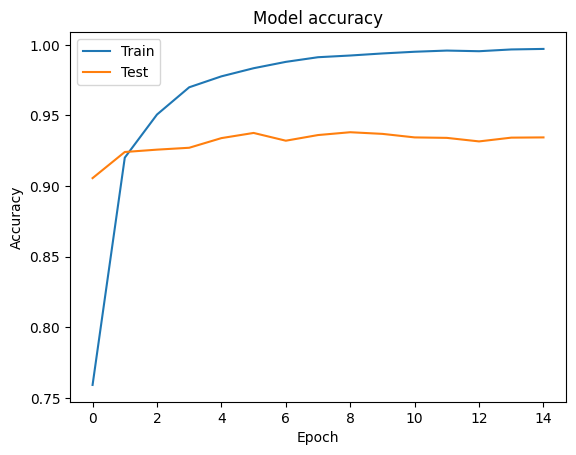

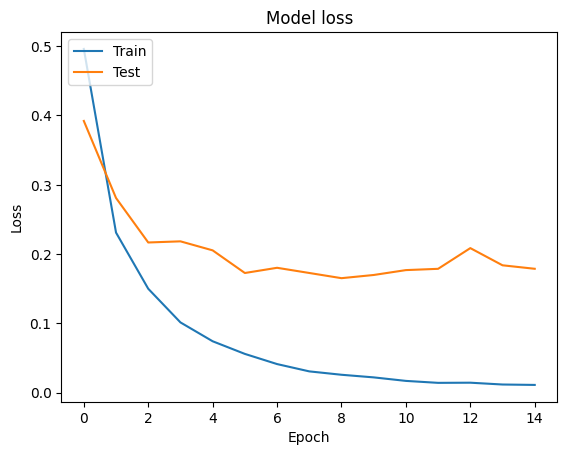

In [32]:
import matplotlib.pyplot as plt

# accuracy на train И val
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# lossы на train и val
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Без предобработки текста с такой архитектурой accuracy = 0.934**

# 6. Векторизация текста - удаление стопслов и спец.симвоплов

In [34]:
text_stop = [' '.join(stopwords_special(d)) for d in text]

In [35]:
X_train_stop, X_test_stop, y_train_stop, y_test_stop = train_test_split(text_stop, real, test_size=0.2, random_state=42)

In [36]:
token_stop = Tokenizer()
token_stop.fit_on_texts(X_train_stop)

In [37]:
word_idx_stop = token_stop.word_index
v_stop = len(word_idx_stop)
print("Размер словаря = ", v_stop)

Размер словаря =  169448


In [38]:
X_train_stop = token_stop.texts_to_sequences(X_train_stop)
X_test_stop = token_stop.texts_to_sequences(X_test_stop)

In [39]:
X_train_stop = pad_sequences(X_train_stop, maxlen=250)
X_test_stop = pad_sequences(X_test_stop, maxlen=250)

# 7. Создание и обучение модели - удаление стопслов и спец.символов

In [41]:
input2 = Input(shape=(250,))
learning_rate = 1e-4

x = Embedding(v_stop+1,100)(input2)
x = Dropout(0.5)(x)
x = LSTM(150,return_sequences=True)(x)
x = Dropout(0.5)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)

model_stop = Model(input2, x)

# Оптимайзер
optimizer = Adam(learning_rate=learning_rate)

model_stop.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
model_stop.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 250, 100)          16944900  
                                                                 
 dropout_3 (Dropout)         (None, 250, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 250, 150)          150600    
                                                                 
 dropout_4 (Dropout)         (None, 250, 150)          0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 150)              0         
 balMaxPooling1D)                                                
                                                           

In [43]:
label_encoder_stop = LabelEncoder()
y_train_encoded_stop = label_encoder_stop.fit_transform(y_train_stop)
y_test_encoded_stop = label_encoder_stop.transform(y_test_stop)

In [44]:
y_train_one_hot_stop = tensorflow.keras.utils.to_categorical(y_train_encoded_stop)
y_test_one_hot_stop = tensorflow.keras.utils.to_categorical(y_test_encoded_stop)

In [45]:
history_stop = model_stop.fit(X_train_stop, y_train_one_hot_stop, epochs=15, validation_data=(X_test_stop, y_test_one_hot_stop))

Epoch 1/15
750/750 [==============================] - 802s 1s/step - loss: 0.5117 - accuracy: 0.7511 - val_loss: 0.4041 - val_accuracy: 0.8381
Epoch 2/15
750/750 [==============================] - 799s 1s/step - loss: 0.2766 - accuracy: 0.9018 - val_loss: 0.3501 - val_accuracy: 0.9086
Epoch 3/15
750/750 [==============================] - 800s 1s/step - loss: 0.1788 - accuracy: 0.9449 - val_loss: 0.2502 - val_accuracy: 0.9140
Epoch 4/15
750/750 [==============================] - 801s 1s/step - loss: 0.1169 - accuracy: 0.9660 - val_loss: 0.2293 - val_accuracy: 0.9166
Epoch 5/15
750/750 [==============================] - 795s 1s/step - loss: 0.0768 - accuracy: 0.9785 - val_loss: 0.2203 - val_accuracy: 0.9185
Epoch 6/15
750/750 [==============================] - 793s 1s/step - loss: 0.0537 - accuracy: 0.9845 - val_loss: 0.2158 - val_accuracy: 0.9185
Epoch 7/15
750/750 [==============================] - 790s 1s/step - loss: 0.0400 - accuracy: 0.9882 - val_loss: 0.2092 - val_accuracy: 0.9180

In [46]:
loss_stop, accuracy_stop = model_stop.evaluate(X_test_stop, y_test_one_hot_stop)

print("Test Loss:", loss_stop)
print("Test Accuracy:", accuracy_stop)

188/188 [==============================] - 36s 190ms/step - loss: 0.2680 - accuracy: 0.9180
Test Loss: 0.2680051624774933
Test Accuracy: 0.9179726839065552


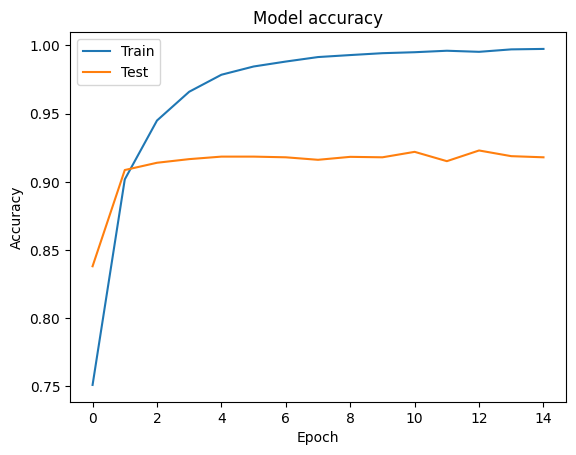

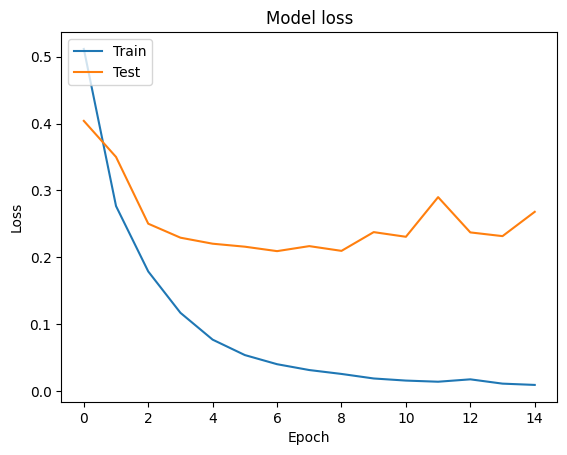

In [47]:
# accuracy на train И val
plt.plot(history_stop.history['accuracy'])
plt.plot(history_stop.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# lossы на train и val
plt.plot(history_stop.history['loss'])
plt.plot(history_stop.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**На этой архитектуре и гиперпараметрах при удалении стопслов в тексте удалось достичь accuracy = 0.918**